In [1]:
# Necesario para un exportado lindo a html
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Esconder/mostrar código"></form>''')

In [2]:
# Load defunciones
%matplotlib inline
import pandas as pd
import json, os

# Locals v/s floydhub
if 'TERM_PROGRAM' in os.environ:
    input_path = '../datasets/defunciones-decoded/'
else:
    input_path = '/floyd/input/defunciones/'

# Dtypes
# Load dtypes from json
with open(input_path + 'dtypes.json') as json_data:
    read_dtypes = json.load(json_data)
date_fields = []

# Capture datetime fields
for col in read_dtypes:
    if read_dtypes[col] == 'datetime64[ns]':
        date_fields.append(col)
        
# Remove datetime fields
for field in date_fields:
    del read_dtypes[field]
    
defunciones = pd.read_csv(
    input_path + 'defunciones-deis-1998-2016-parsed-1M.csv',
    dtype=read_dtypes,
    parse_dates=date_fields,
    index_col=False
)

# Load cie-10 codes
cie10 = pd.read_csv(input_path + 'cie-10.csv').set_index('code')
def describe_cie10_index(Series):
    tmp = pd.Series()
    for row in Series.items():
        tmp[cie10.loc[row[0]].description + '\n' + row[0]] = row[1]
    return tmp

In [3]:
def describe_cie10_index(Series):
    tmp = pd.Series()
    for row in Series.items():
        tmp[cie10.loc[row[0]].description + '\n' + row[0]] = row[1]
    return tmp

# Lenguaje de programación y testeo estadístico: el caso de Ventanas
## Una comparativa entre la zona crítica y resto de Chile
### Introducción
Mediante programación en phyton es posible estandarizar en forma sencilla los registros de defunciones oficiales, que tienen una serie de variaciones año a año. Una vez construida una [unificación de los registros de defunciones en Chile, entre el año 1998 y 2016](https://github.com/verasativa/defunciones-decoder), surge la pregunta general: ¿Se podrán observar en éste, rasgos distintos en una zona crítica al resto de Chile? Con el mismo lenguaje de programación podría testearse esa hipótesis.
### Comparación de diagnósticos primarios
Apalancándose en la integración jerárquica, de los códigos de diagnóstico CIE-10 en el dataset. Una comparación de éstos, se presenta como la opción más evidente y atractiva, pero con algunas consideraciones.
### Limitaciones
Dado que este dataset solo incluye las defunciones, y no contiene información sobre la población general, no es posible hacer un análisis respecto a tasas de ocurrencia, sin tener que argumentar con otros datos como censos. Además la ruralidad de la zona, conjugada con la migración campo-ciudad, produce una población envejecida. Tampoco podemos hacer un análisis sobre la distribución etaria de la mortalidad, ni la distribución de diagnósticos primarios en la población general, sin normalizar primero con datos adicionales.
### Pregunta de investigación
Con esas limitaciones en mente, podemos plantear una pregunta sencilla, pero contestable:

__¿Como se comparan los diagnósticos primarios de defunciones, en la zona de interés con respecto al resto del país, en menores de 16 años?__

### Proceso exploratorio: definiendo la "zona de interés"
Inicialmente se exploramos como zona de interés solamente las comunas de Quintero y Puchuncaví, razón de ser las directamente colindates con el foco industrial de contaminación.


In [ ]:
def join_codes(row):
    values_to_join = ['P00-P96','Q00-Q99']
    if row['primary_code_0'] in values_to_join:
        row['primary_code_0'] =  'P00-P96+Q00-Q99'
    return row

new_code = {
    'description': 'Ciertas afecciones originadas en el período perinatal + Malformaciones congénitas, deformidades y anomalías cromosómicas',
    'level': 0,
    'source': 'custom'
}
cie10 = cie10.append(pd.Series(data=new_code, name='P00-P96+Q00-Q99'))

Zona de interés: ['Quintero', 'Puchuncaví']
Total defunciones en el grupo de interés: 119
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 118
Fracción del total: 0.992


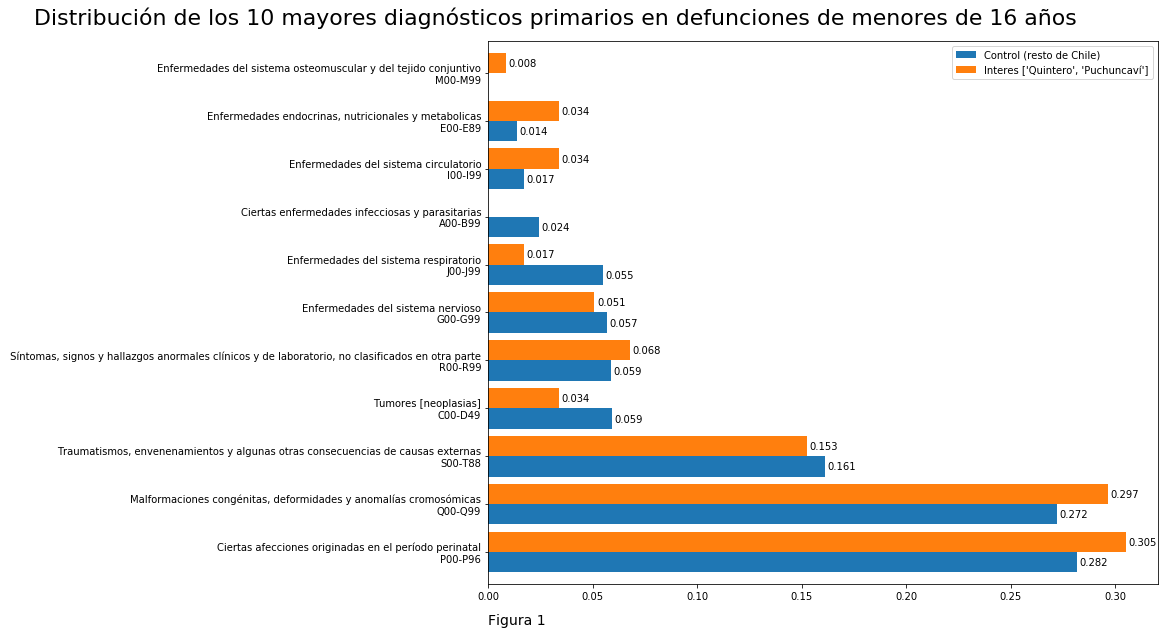

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos función para uso reiterado
def compare_primary_diagnosis(poblacion, comunas_interes, top_n = 10, footer = False):
    # Creamos grupos
    defunciones_test = poblacion.query('comune in @comunas_interes') # Menores en zona de interes
    defunciones_control = poblacion.query('comune not in @comunas_interes') # Menores resto de Chile (control)
    
    # Imprimimos información general
    print('Zona de interés: {}'.format(comunas_interes))
    print('Total defunciones en el grupo de interés: {}'.format(defunciones_test.shape[0]))    
    print('Total defunciones en los {} principales diagnósticos primarios del grupo de interés: {}'.format(
        top_n,
        defunciones_test.primary_code_0.value_counts()[:top_n].sum()
    ))
    print('Fracción del total: {0:.3f}'.format(defunciones_test.primary_code_0.value_counts()[:top_n].sum()/defunciones_test.shape[0]))
    
    # Ploteo
    # Los x diágnosticos primarios mayores en control
    incidencias_control = pd.DataFrame(describe_cie10_index(defunciones_control.primary_code_0.value_counts()[:top_n]), columns=['Control'])
    # Los x diágnosticos primarios mayores en interés
    incidencias_test = pd.DataFrame(describe_cie10_index(defunciones_test.primary_code_0.value_counts()[:top_n]), columns=['Interés'])
    # Concatenamos
    comparativa = pd.concat([incidencias_control, incidencias_test], axis=1, sort=False)
    # A fracción
    comparativa['Control (resto de Chile)'] = comparativa.Control / comparativa.Control.sum()
    comparativa['Interes {}'.format(comunas_interes)] = comparativa.Interés / comparativa.Interés.sum()
    del comparativa['Control']
    del comparativa['Interés']
    ax = comparativa.plot(kind='barh',
                          figsize=(12,10),
                          width=.85)
    ax.set_title('Distribución de los {} mayores diagnósticos primarios en defunciones de menores de 16 años'.format(top_n), size=22, y=1.02, x=.1)
    for p in ax.patches:
        if p.get_width() != 0:
            ax.annotate(np.round(p.get_width(),decimals=3), 
                        (p.get_width()+.008, p.get_y()),
                        ha='center',
                        va='center',
                        xytext=(0, 10),
                        textcoords='offset points')
    if footer:
        plt.annotate(footer, (0,0), (0, -1.5), fontsize=14)
    file_name = '{}-diagnósticos-({}).png'.format(top_n, '-'.join(comunas_interes).replace(' ', ''))
    plt.savefig('assets/' + file_name, bbox_inches='tight')
    plt.show()
    plt.close()
    
# Seleccionamos menores
poblacion = defunciones.query('(age_type == "años" and age_amount <= 16) or (age_type in ["meses", "días", "horas"])') #.apply(join_codes, axis=1)
comunas_interes = ["Quintero", "Puchuncaví"]
compare_primary_diagnosis(poblacion, comunas_interes, footer = 'Figura 1')

Sin embargo, podemos obvservar en la figura 1, que hay dos diagnoticos primarios que pesentan incidencias superiores a la nacional, con la intención de buscar una tendencia más clara y validable (tamaño de la muestra), exploramos la incidencia de estos dos díagnoticos primarios en todas las comunas de la quinta región.

In [5]:
#poblacion
diagnosticos_interes = ["P00-P96", "Q00-Q99"]
# Creamos grupos
defunciones_region = poblacion.query('home_region == "Valparaíso"') # Menores en zona de interes
for diagnostico in diagnosticos_interes:
    ddf = pd.DataFrame()
    for comuna in defunciones_region.comune.unique():
        #display(comuna)
        incidencia_otros = poblacion.query('comune != @comuna and primary_code_0 == @diagnostico').shape[0]
        total_otros = poblacion.query('comune != @comuna').shape[0]
        taza_otros = incidencia_otros / total_otros
        
        incidencia_comuna = poblacion.query('comune == @comuna and primary_code_0 == @diagnostico').shape[0]
        total_comuna = poblacion.query('comune == @comuna').shape[0]
        taza_comuna = incidencia_comuna / total_comuna
        
        fila = {
            'Comuna': comuna,
            'Incidencia otros': incidencia_otros,
            'Total otros': total_otros,
            'Taza otros': taza_otros,
            'Incidencia comuna': incidencia_comuna,
            'Total comuna': total_comuna,
            'Taza comuna': taza_comuna,
        }
        ddf = ddf.append(fila, ignore_index=True)
    print('{} ({})'.format(cie10.loc[diagnostico].description, diagnostico))
    display(ddf.sort_values('Taza comuna', ascending=False)[:12].reset_index(drop=True))

Ciertas afecciones originadas en el período perinatal (P00-P96)


,Comuna,Incidencia comuna,Incidencia otros,Taza comuna,Taza otros,Total comuna,Total otros
0,La Cruz,26.0,15957.0,0.509804,0.274836,51.0,58060.0
1,Rinconada,15.0,15968.0,0.468750,0.274936,32.0,58079.0
2,San Felipe,109.0,15874.0,0.374570,0.274542,291.0,57820.0
3,Olmué,17.0,15966.0,0.369565,0.274968,46.0,58065.0
4,El Tabo,7.0,15976.0,0.368421,0.275012,19.0,58092.0
5,San Esteban,15.0,15968.0,0.357143,0.274983,42.0,58069.0
6,Cartagena,18.0,15965.0,0.339623,0.274984,53.0,58058.0
7,Llaillay,28.0,15955.0,0.337349,0.274953,83.0,58028.0
8,Calle Larga,13.0,15970.0,0.333333,0.275003,39.0,58072.0
9,Algarrobo,11.0,15972.0,0.323529,0.275014,34.0,58077.0


Malformaciones congénitas, deformidades y anomalías cromosómicas (Q00-Q99)


,Comuna,Incidencia comuna,Incidencia otros,Taza comuna,Taza otros,Total comuna,Total otros
0,Puchuncaví,20.0,15428.0,0.434783,0.265702,46.0,58065.0
1,Zapallar,6.0,15442.0,0.428571,0.265797,14.0,58097.0
2,Papudo,3.0,15445.0,0.375000,0.265821,8.0,58103.0
3,La Ligua,37.0,15411.0,0.370000,0.265657,100.0,58011.0
4,Concón,30.0,15418.0,0.352941,0.265708,85.0,58026.0
5,Nogales,20.0,15428.0,0.333333,0.265766,60.0,58051.0
6,Cabildo,20.0,15428.0,0.333333,0.265766,60.0,58051.0
7,Putaendo,19.0,15429.0,0.322034,0.265779,59.0,58052.0
8,El Tabo,6.0,15442.0,0.315789,0.265820,19.0,58092.0
9,Quillota,78.0,15370.0,0.308300,0.265650,253.0,57858.0


Al obvservar las tablas de incidencia, podemos notar que el díagnostico primario "Ciertas afecciones originadas en el período perinatal", esta dominado por otras comunas, y no primariamente las de la zona de interés. Y por otra parte el diagnotico primario de "Malformaciones congénitas, deformidades y anomalías cromosómicas" domina en comunas colindantes con la centro industrial.
Ante esto, decidimos graficar la incidencia de interes en el mapa.

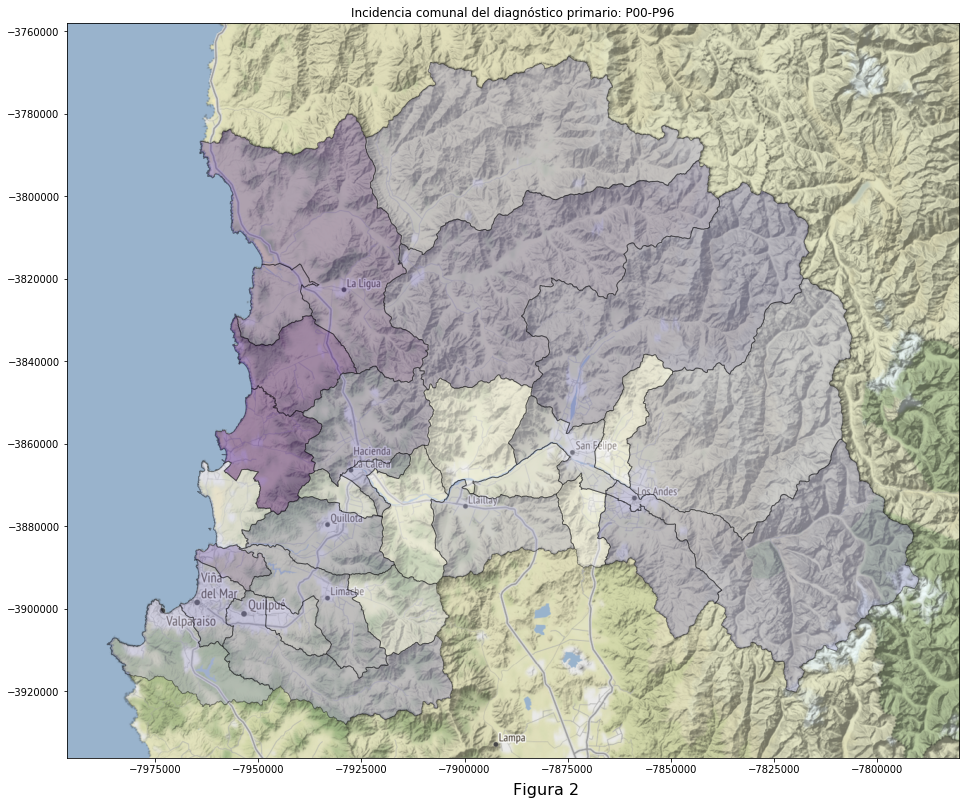

Incidencia comunal del diagnóstico primario: P00-P96


,Comuna,Taza comuna,Taza otros,Incidencia comuna,Total comuna,Incidencia otros,Total otros
0,Puchuncaví,0.434783,0.265702,20,46,15428,58065
1,Zapallar,0.428571,0.265797,6,14,15442,58097
2,Papudo,0.375000,0.265821,3,8,15445,58103
3,La Ligua,0.370000,0.265657,37,100,15411,58011
4,Concón,0.352941,0.265708,30,85,15418,58026
5,Nogales,0.333333,0.265766,20,60,15428,58051
6,Cabildo,0.333333,0.265766,20,60,15428,58051
7,Putaendo,0.322034,0.265779,19,59,15429,58052
8,Quillota,0.308300,0.265650,78,253,15370,57858
9,Calle Larga,0.307692,0.265808,12,39,15436,58072


<Figure size 432x288 with 0 Axes>

In [6]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import sys

comunas_mapa = ['Panquehue', 'Los Andes', 'Rinconada',
       'San Esteban', 'Cabildo', 'La Ligua', 'Papudo', 'Petorca',
       'Zapallar', 'Hijuelas', 'La Cruz', 'Nogales', 'Quillota', 'Catemu',
       'Llaillay', 'Calera', 'Putaendo', 'San Felipe', 'Santa María',
       'Concón', 'Puchuncaví', 'Quintero', 'Valparaíso', 'Viña del Mar',
       'Calle Larga', 'Olmué', 'Quilpué', 'Villa Alemana', 'Limache']
diagnostico = 'Q00-Q99'
file_name = 'assets/mapa0.png'
title = "Incidencia comunal del diagnóstico primario: P00-P96"

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
def geo_diagnoses(comunas_mapa):
    return True

# Calcular la incidencia por comuna
# acumulador
incidencia_comunas = pd.DataFrame()
for comuna in comunas_mapa:
    #display(comuna)
    incidencia_otros = poblacion.query('comune != @comuna and primary_code_0 == @diagnostico').shape[0]
    total_otros = poblacion.query('comune != @comuna').shape[0]
    taza_otros = incidencia_otros / total_otros

    incidencia_comuna = poblacion.query('comune == @comuna and primary_code_0 == @diagnostico').shape[0]
    total_comuna = poblacion.query('comune == @comuna').shape[0]
    taza_comuna = incidencia_comuna / total_comuna

    fila = {
        'Comuna': comuna,
        'Taza comuna': taza_comuna,
        'Taza otros': taza_otros,
        'Incidencia comuna': incidencia_comuna,
        'Total comuna': total_comuna,
        'Incidencia otros': incidencia_otros,
        'Total otros': total_otros,
    }
    incidencia_comunas = incidencia_comunas.append(fila, ignore_index=True)
incidencia_comunas = incidencia_comunas.astype({'Incidencia otros': int, 'Total otros': int, 'Incidencia comuna': int, 'Total comuna': int})

# Para que coincida con geodataframe de comunas de Chile
incidencia_comunas['NOM_COM'] = incidencia_comunas.Comuna
# Cargamos vectores de comunas
geo_comunas = gpd.read_file('../datasets/division_comunal/', crs={'init': 'epsg:5361'})
del geo_comunas['SHAPE_Le_1']
geo_comunas = geo_comunas.query('NOM_COM in @comunas_mapa')
geo_incidencia = geo_comunas.merge(incidencia_comunas, how='left', on='NOM_COM')
geo_incidencia = geo_incidencia.to_crs({'init': 'epsg:3857'})
ax = geo_incidencia.plot(column='Taza comuna', figsize=(16,20), alpha=0.4, edgecolor='k', cmap='Purples')
ax.annotate("Figura 2", (0,0), xycoords='axes fraction', xytext=(.5, -.05), textcoords='axes fraction', fontsize=16)
add_basemap(ax, zoom=10)
plt.title(title)
plt.show()
plt.savefig(file_name, bbox_inches='tight')

# Data frame
print(title)
incidencia_comunas_friendly = incidencia_comunas.sort_values('Taza comuna', ascending=False).reset_index(drop=True).drop(columns='NOM_COM').reindex(fila.keys(), axis=1)
display(incidencia_comunas_friendly)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_ages(
    poblacion, 
    comunas_interes = 'all', 
    top_n = 2, 
    limit_years = .5, 
    top_limit = False, 
    bins = 10, 
    bw = False,
    second_line_title = ''):   
    # Creamos grupos
    if comunas_interes == 'all':
        data = poblacion
    else:
        data = poblacion.query('comune in @comunas_interes') # Menores en zona de interes

    def set_universal_year(row):
        if row['age_type'] == 'días':
            row['age_years'] = row['age_amount'] * (1 / 365.25)
            row['age_days'] = row['age_amount']
        if row['age_type'] == 'horas':
            row['age_years'] = row['age_amount'] * (1 / (365.25 * 24))
            row['age_days'] = row['age_amount'] / 24
        if row['age_type'] == 'meses':
            row['age_years'] = row['age_amount'] * (1 / 12)
            row['age_days'] = row['age_amount'] * (365.25 / 12)
        if row['age_type'] == 'años':
            row['age_years'] = row['age_amount']
            row['age_days'] = row['age_amount'] * 365.25
        return row
    data = data.apply(set_universal_year, axis=1).query('age_years <= @limit_years')
    top_diagnoses = data.primary_code_0.value_counts()[:top_n].index
    #display(data.primary_code_0.value_counts()[:5])
    title = 'Distribución de edades por causa de defuncíón en {} \n{}'.format(comunas_interes, second_line_title)
    fig, ax = plt.subplots(1, figsize=(16,12))
    handles = []
    for primary_diag in top_diagnoses:
        mask = data.primary_code_0 == primary_diag
        label = '{}\n{} ({})'.format(cie10.loc[primary_diag].description, primary_diag, data[mask].shape[0])
        kde_kws = {}
        if bw:
            kde_kws['bw'] = bw
        ax = sns.distplot(data[mask].age_years.values, ax=ax, bins=10, label=label, kde_kws=kde_kws)
    else:
        label = 'Todos ({})'.format(data.shape[0])
        ax = sns.distplot(data.age_years.values, ax=ax, bins=bins, label=label, hist=False)
    ax.set_title(title, size=15, y=1.02)
    ax.set_xlim(left=0, right=(limit_years - .05))
    if top_limit:
        ax.set_ylim(top=top_limit)
    
    # Draw months
    if limit_years <= 2:
        mes = 1 / 12
        for mes_count in range(1, 6):
            ax.axvline(mes * mes_count, ymax=.25, color='grey', alpha=.5)
            foo = plt.text((mes * mes_count) + .01, 15, 'Mes {}'.format(mes_count), fontsize=8)
    #data.age_years.hist()
    plt.legend()
    plt.show()
    plt.close()
    
##compare_ages(poblacion, comunas_interes, second_line_title = 'Primeros 6 meses', top_n=3)

#compare_ages(poblacion, comunas_interes, limit_years=16.5, top_limit=2, top_n=3, bw=.3, second_line_title = 'Primeros 16 años')
##compare_ages(poblacion, comunas_interes, limit_years=2, top_limit=22, bw=.03, second_line_title = 'Primeros 2 años', top_n=3)
#compare_ages(poblacion, comunas_interes, second_line_title = 'Primeros 6 meses', top_n=2)

#diagnosticos = ['P00-P96','Q00-Q99']
#group = defunciones.query('primary_code_0 in @diagnosticos')
#compare_ages(group, limit_years=100.5, top_n=2, bw=.03)

### Ampliar la zona de interés
Si bien se pueden apreciar diferencias en la incidencia de los diagnoticos primarios, la diferencia que se aprecia es poca y siendo la muestra de 119 casos en 18 años, intuimos que será dificil validarla posteriormente. Para lo que repetimos el ejercicio, pero esta vez ampliando la zona de busqueda incluyendo nuevas comunas.

### Se revela un diagnotico primario anormalmente dominante
En este punto, y con una muestra de 300+ casos, el diagnostico primario "Malformaciones congénitas, deformidades y anomalías cromosómicas" (CIE-10: Q00-Q99), es considerablemente más alto en el grupo de interés, por sobre el grupo de control (34.7% por sobre 27.2%).
### ¿Como de distribuye el alza de el diagnotico primario de interés en la zona?
Ante los resultado anteriores, surje la duda de como se distribuye este diagnotico en la zona, a fin de poder definir más acusiosamente la zona de interés. A fin de hechar luz a esta duda, graficaremos la incidencia de este diagnotico en defunciones de menores de 16 años, por comuna sobre un mapa.

### Se observa una distribución no-radial: ¿Cómo se explica?
En la figura se puede apreciar que las comunas más afectadas parecen ser las directamente al norte (Puchuncaví, Zapallar, Papudo y La Ligua), al este (Nogales, La Calera y Quillota)

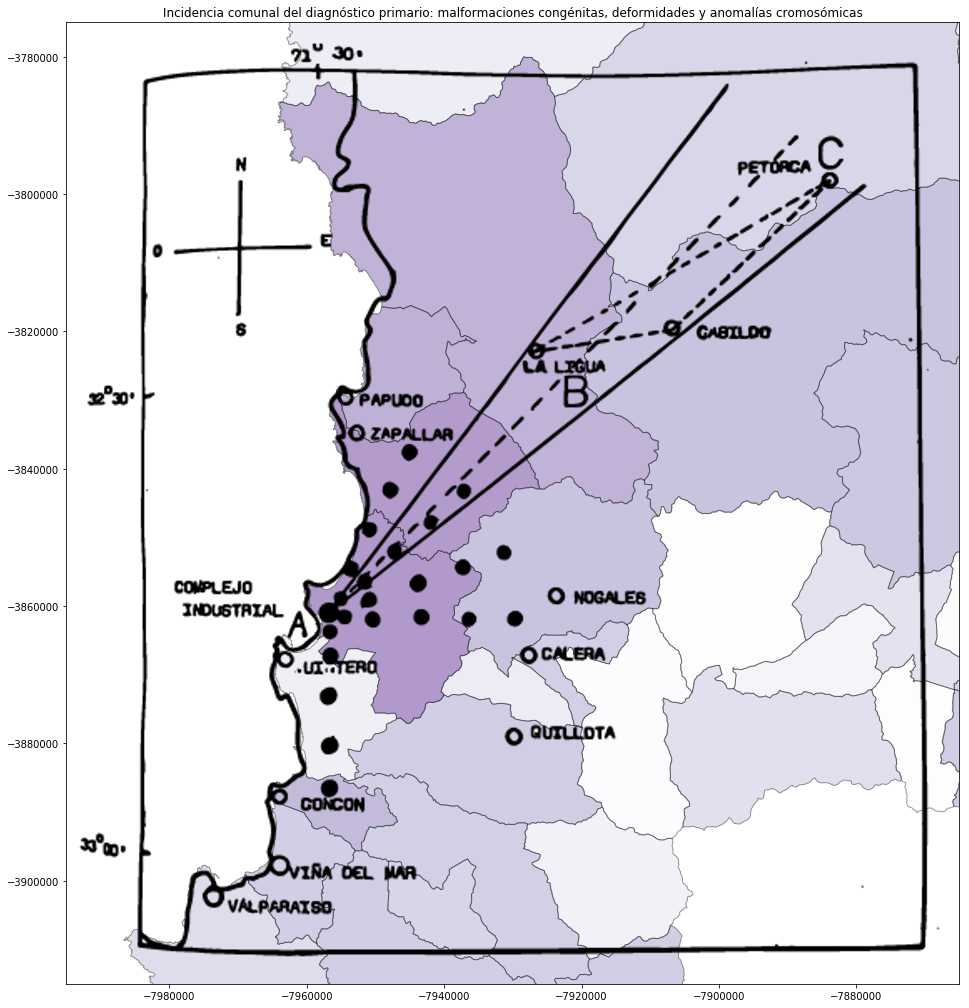

In [26]:
import matplotlib.pyplot as plt


ax = cdata.plot(column='rate', figsize=(16,20), alpha=0.4, edgecolor='k', cmap='Purples')
#add_basemap(ax, zoom=10)
plt.title("Incidencia comunal del diagnóstico primario: malformaciones congénitas, deformidades y anomalías cromosómicas")

modelo_pluma = plt.imread('assets/figura.png')
xmin, xmax, ymin, ymax = ax.axis()
ax.imshow(modelo_pluma, extent=[xmin, xmax, ymin, ymax], interpolation='spline16', zorder=1)
ax.axis((-7995000, -7865000, -3915000, -3775000))
plt.savefig('assets/mapa-pluma.png', bbox_inches='tight')

__Algunos datos sobre los grupos:__

Zona de interés: ['Puchuncaví', 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales']
Total defunciones en el grupo de interés: 313
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 308
Fracción del total: 0.984


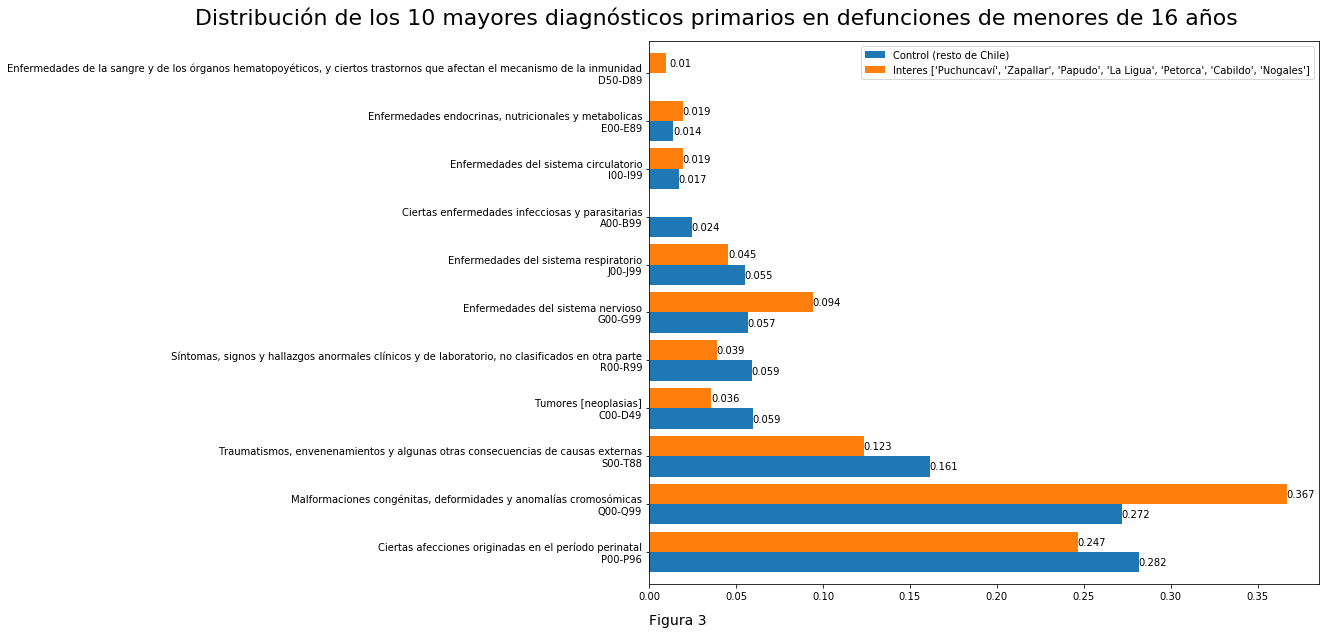

In [7]:
comunas_interes = ["Puchuncaví", 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales']
compare_primary_diagnosis(poblacion, comunas_interes, footer = 'Figura 3')

Zona de interés: ['Puchuncaví', 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón', 'Quintero']
Total defunciones en el grupo de interés: 471
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 462
Fracción del total: 0.981


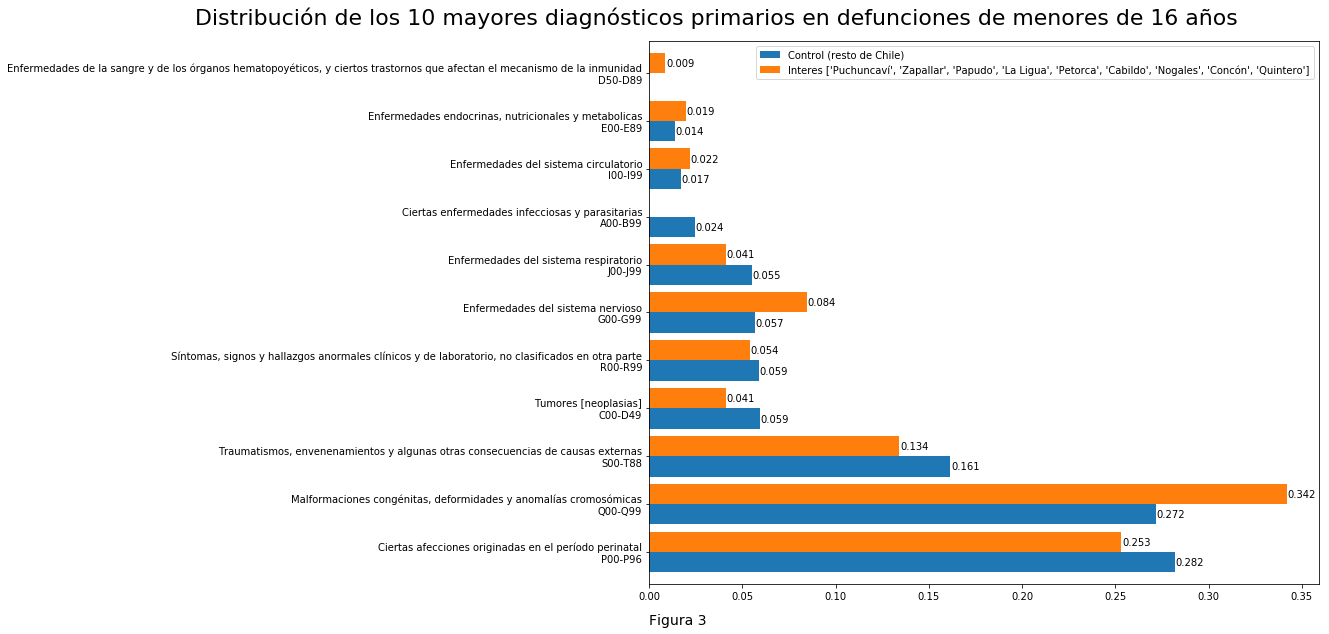

In [8]:
comunas_interes = ["Puchuncaví", 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón', 'Quintero']
compare_primary_diagnosis(poblacion, comunas_interes, footer = 'Figura 3')

Zona de interés: ['Puchuncaví', 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón']
Total defunciones en el grupo de interés: 398
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 390
Fracción del total: 0.980


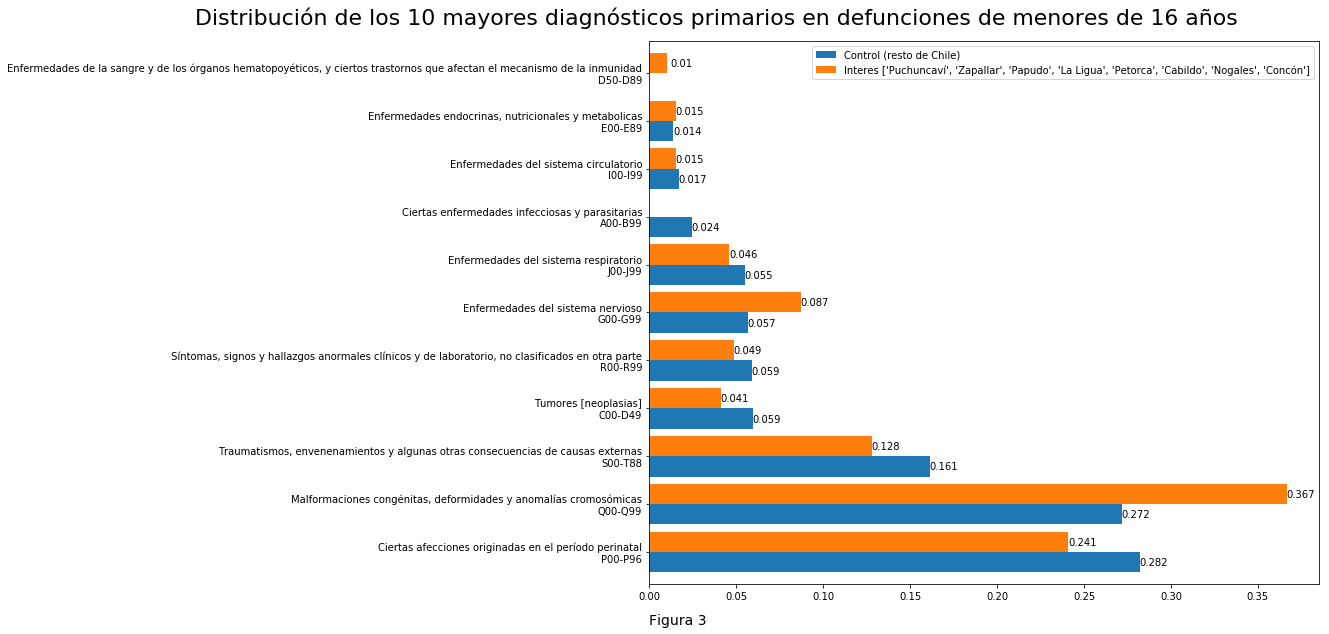

In [9]:
comunas_interes = ["Puchuncaví", 'Zapallar', 'Papudo', 'La Ligua', 'Petorca', 'Cabildo', 'Nogales', 'Concón']
compare_primary_diagnosis(poblacion, comunas_interes, footer = 'Figura 3')

## Observaciones
Al comparar estos gráficos, inmediatamente notamos que el diagnostico primario "Malformaciones congénitas, deformidades y anomalías cromosómicas" (CIE-10: Q00-Q99), es considerablemente más alto en el grupo de interés, por sobre el grupo de control (34.8% por sobre 27.2%).
## Validación
Para validar esta observación, realizaremos una prueba de permutación:

Tomamos 1.000.000 de muestras del mismo tamaño que el grupo de interés (326) desde el grupo de control, y observaremos la distribución del diagnostico primario de interés en estas muestras, a fin de responder:

__¿Qué tan probable es observar la incidencia (34.8%) que se da nuestro grupo de interés, en cualquier otro grupo del mismo tamaño muestreado al azar desde el grupo de control?__ (azar en contraste con casos seleccionados por zona geográfica de interés)

In [9]:
from tqdm.auto import tqdm
sample_size = defunciones_test.shape[0] # 326
n_simulaciones = 10 ** 6
simulaciones = []
for i in tqdm(range(n_simulaciones), unit='muestras'):
    sample = defunciones_control.sample(n=sample_size).primary_code_0.value_counts()[:top_n]
    simulaciones.append(sample['Q00-Q99']/sample.sum()) # Malformaciones congénitas, deformidades y anomalías cromosómicas
simulaciones = pd.DataFrame(simulaciones, columns=['fraccion'])
simulaciones.to_pickle('simulaciones{}.pk'.format(n_simulaciones))

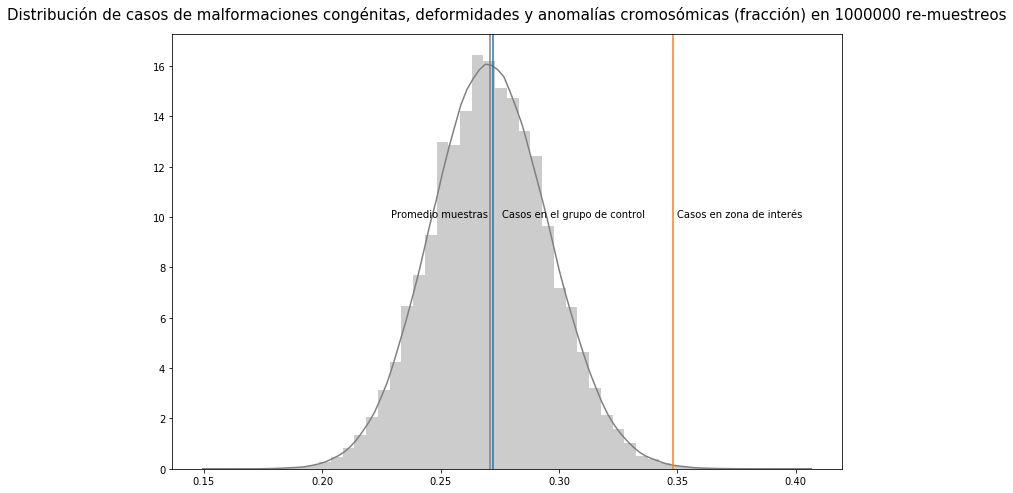

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

title = 'Distribución de casos de malformaciones congénitas, deformidades y anomalías cromosómicas (fracción) en {} re-muestreos'.format(n_simulaciones)
plt.figure(figsize=(12, 8))
ax = sns.distplot(simulaciones.fraccion.values, color='grey', bins=50).set_title(title, size=15, y=1.02)
plt.axvline(.348, label="", color='tab:orange')
foo = plt.text(.35,10,'Casos en zona de interés')
plt.axvline(.272, label="")
foo = plt.text(.276,10,'Casos en el grupo de control')
plt.axvline(simulaciones.fraccion.mean(), label="", color='grey')
foo = plt.text(simulaciones.fraccion.mean()-.042, 10,'Promedio muestras')
mp.savefig('assets/distribucion.png', bbox_inches='tight')

## Otros valores de interés
El gráfico anterior, muestra que es extremadamente improbable obtener la incidencia del diagnostico primario de interés (malformaciones congénitas, deformidades y anomalías cromosómicas), que se observa la zona de interés, desde muestras del mismo tamaño tomadas al azar desde el resto de Chile.

A continuación cuantificamos la observación anterior con los siguientes números:
 - Probabilidad de obtener este resultado o más al azar (P-Value)
 - Incidencia promedio en muestras al azar desde el grupo de control
 - Desviación standard de muestras al azar desde el grupo de control
 - Cuantificación en desviaciones standards de cuanto se aleja la observación de interés desde el promedio de los 10.000 re-muestreos

In [21]:
# Probabilidad de obtener este resultado o más al azar (P-Value)
pvalue = simulaciones.query('fraccion > .348').shape[0] / simulaciones.shape[0]
print('P-value: {:.4f}'.format(pvalue))

# Promedio de muestras
promedio_muestras = simulaciones.fraccion.mean()
print('Promedio de las muestras: {:.4f}'.format(promedio_muestras))

# Desviación standar
std = simulaciones.fraccion.std()
print('Desviación standard de las muestras: {:.4f}'.format(std))

# ¿cuantas desviaciones standards se aleja?
std_delta = (.348 - simulaciones.fraccion.mean()) / simulaciones.fraccion.std()
print('Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: {:.2f}'.format(std_delta))

P-value: 0.0011
Promedio de las muestras: 0.2709
Desviación standard de las muestras: 0.0247
Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: 3.12


## Variaciones en el P-value
A razón de haber observado variaciones en el primer dígito no-cero del P-value en las primeras ejecuciones de 10.000 re-muestreos, se aumento la cantidad de re-muestreos en 2 ordenes de magnitud. Y para entender como se comporta este P-value respecto a la cantidad de re-muestreos, se toman sub-muestras del millón de muestras en incrementos de 500. Al graficar, el P-value en estas distintas cantidades de re-muestreos, se observa que con el n inicial de 10.000 se lograba estabilizar en su orden de magnitud (~0.01%), con un millón se logran estabilizar los primeros dos dígitos que no son cero (0.011%).

In [ ]:
p_values = pd.DataFrame()
step = 500
for n_samples in range(step, n_simulaciones, step):
    current_sample_set = simulaciones.sample(n=n_samples)
    pvalue = current_sample_set.query('fraccion > .348').shape[0] / current_sample_set.shape[0]
    data = {
        'N resamples': current_sample_set.shape[0],
        'P-value': pvalue
    }
    p_values = p_values.append(data, ignore_index=True)

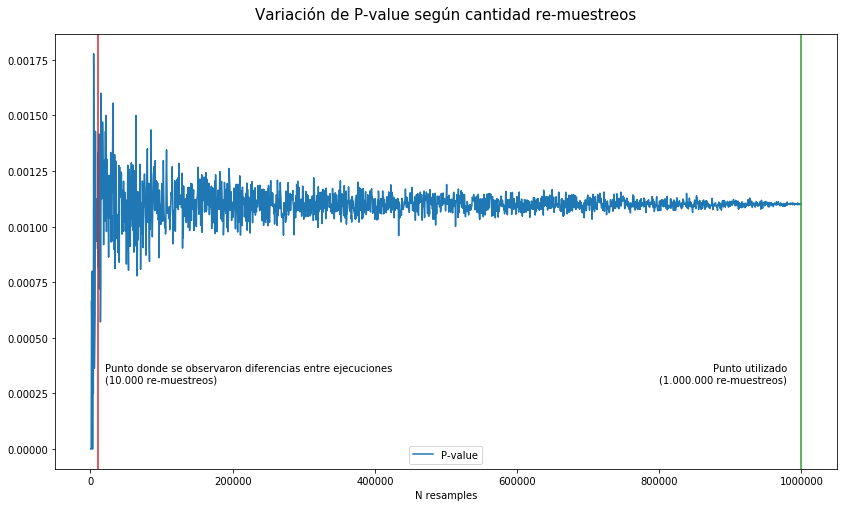

In [27]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
p_values.set_index('N resamples').plot(figsize=(14,8)).set_title('Variación de P-value según cantidad re-muestreos', size=15, y=1.02)

# Anotamos
plt.axvline(10000, label="", color='tab:red')
foo = plt.text(20000,.0003,'Punto donde se observaron diferencias entre ejecuciones\n(10.000 re-muestreos)')

plt.axvline(1000000, label="", color='tab:green')
foo = plt.text(980000,.0003,'Punto utilizado\n(1.000.000 re-muestreos)', horizontalalignment='right')

foo = mp.savefig('assets/variacion-p-values.png', bbox_inches='tight')

## Conclusiones
Con una posibilidad de 0.11% de encontrar el nivel de incidencia del diagnóstico _malformaciones congénitas, deformidades y anomalías cromosómicas_ (CIE-10: Q00-Q99) que se presenta en la zona de interés (34.8%) o mayor, podemos asumir que la incidencia mayor observada no es producto del azar. Correspondería a los expertos del área (salud, bioquímica, ecología, etc.) plantear rutas específicas que llevan al incremento de las defunciones bajo este diagnóstico primario. Y por otra parte a los gobernantes hacer la prueba de campo, descartando las causales en sospecha, para poder observar en algunas décadas, la evolución de la incidencia de este diagnóstico primario en las defunciones de la zona.

### Potencial futuro de la metodología
La técnica particular puede ser escalada para buscar este tipo de fenómenos a nivel nacional sin especificar una zona en particular, lo que podría revelar problemas de salud pública fuera del "radar" de los investigadores. Para esto se requeriría construir un graph con comunas como nodos, y sus colindacias geográficas como vértices (tal vez con [estos vectores](https://www.bcn.cl/siit/mapas_vectoriales/index_html)), e iterar sobre grupos de comunas colindantes con un mínimo de registros totales. De realizarse, se sugiere el nombre: _Perico_ para tal script que _treparía por Chile_
#### Contacto
Vera Sativa  
hola@verasativa.com

# Antecedentes y reflexiones sobre la zona de sacrificio de Quintero y Puchuncaví

7. Antecedentes de contaminación del aire
En las comunas de Quintero y Puchuncaví está vigente un plan de descontaminación
atmosférico dictado hace 26 años (D.S. N°252/1992), el que tenía por objetivo reducir las
emisiones de dióxido de azufre y material particulado, generadas por las empresas Chilgener
(AES GENER) y ENAMI (CODELCO), así como regular sus emisiones de arsénico con el
fin de cumplir con la norma de “calidad de arsénico respirable”, medida que a la fecha sigue
en incumplimiento.
El 2015, las comunas de Concón, Quintero y Puchuncaví fueron declaradas saturadas para
MP 2.5 anual, en latencia para MP 2.5 diario y MP 10 anual (D.S. N°10/2015). El 2016, el “Consejo
de Ministros para la Sustentabilidad” aprobó (Ministerio del Medio Ambiente, 2016) la
elaboración de un “Plan de Descontaminación y Prevención” (PPDA) que fue rechazado por
la Contraloría General de la República al no ajustarse a derecho al no reducir las emisiones de
contaminantes aportados por CODELCO, GENER y ENAP (Cooperativa.cl, 2017)

9
En la actualidad, se tramita un nuevo PPDA, el cual se espera que esté aprobado durante el
primer semestre de 2019.
En lo que respecta a concentraciones de arsénico respirable, sus niveles en la zona superan
ampliamente lo considerado como riesgo aceptable para países de la Unión Europea
(Astudillo, 2018). En el caso del SO 2 se observan usuales peak (Letra, 2017) en
concentraciones consideradas como dañina para la salud por la OMS, principalmente en las
localidades de Quintero y Los Maitenes.
A pesar que la Bahía de Quintero lidera a nivel nacional la importación, descarga y
almacenamientos de químicos e hidrocarburos líquidos (43,3%) durante el 2016 (Directemar,
2016), la medición de compuestos orgánicos volátiles COV es deficiente y, en muchos casos,
inexistente, debido a la falta de una norma de “Calidad Primaria” que permita contar con
mediciones confiables, periódicas y proteja al menos parcialmente a la población. A raíz de
numerosas denuncias en los últimos años por fuerte olores e intoxicaciones de niños en
establecimientos escolares de Quintero y Puchuncaví (Anexo 2), durante el 2017 se encargó a
la “Universidad Santa María” la realización de un estudio (CETAM, 2017) con el fin de
analizar el origen de estos contaminantes, estudio que concluyó que la fuente más probable de
los gases que afectan a la Escuela Santa Filomena en Quintero es GASMAR (Elmostrador.cl,
2017).
La falta de un control en las emisiones aéreas contaminantes del sector industrial quedó
evidenciada con las intoxicaciones masivas ocurridas en los meses de agosto, septiembre y
octubre del 2019, sobre las cuales -a la fecha-, se desconoce el o los tóxico(s) responsables
así como la(s) fuente(s) causante(s) de dichas intoxicaciones.